<a href="https://colab.research.google.com/github/DavidMartinezGonzalez/TutorialOnNeuralVocoders/blob/main/chapter_5_DSP%2BDNN_NSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome


This is the hands-on session for ICASSP 2022 short course **Inclusive Neural Speech Synthesis**, **LECTURE 1, neural vocoder**.

Click [HERE](https://colab.research.google.com/drive/1EO-ggi1U9f2zXwTiqg7AEljVx11JKta7?usp=sharing) to go back to the entry point of this hands-on session.


## About this notebook

In this notebook, we will cover a simple non-autoregressive non-GAN neural waveform model --- neural source-filter waveform model.

We will cover:
1. Pytorch Module Definition (Sec.1)
2. Demonstration on speech generation (Sec.2)
3. Demonstration on music instrument audio generation (Sec.3)


## Preparation

This hands-on session is based on Python (Numpy & Scipy) and Pytorch, and dependency should have been provided by the Colab runtime.

We only need to download some pre-trained models and example data:

In [1]:
!echo "Download external zip "
!wget --quiet --show-progress -O iNSS.zip https://www.dropbox.com/sh/bua2vks8clnl2ha/AABxjrZhQBRM1YEekjWs8Pl2a/iNSS
!echo "Unzip files"
!unzip -q -o iNSS.zip -x / -d /content
!if [ -d "/content/data_models" ]; then echo "Done"; else echo "Please contact with the author"; fi

Download external zip 
iNSS.zip            100%[===================>] 402.88M  49.7MB/s    in 7.4s    
Unzip files
Done


In [2]:
# for convenience, define a path to the folder on Google Colab runtime
g_workpath = '/content'

# Sec.1 Pytorch Module Definition

In this section, we explain and implement a harmonic-plus-noise neural  source-filter waveform model.

The model consists of three parts:

```sh
-----------      noise      -------------------
|         |  -------------> |                 |
|  Source |                 | Neural "filter" |
|  module |  source signal  |     module      | -----> waveform
|         |  -------------> |                 |
-----------                 -------------------
  ^                                 ^
  | upsampled F0                    | upsampled hidden features
-----------------------------------------------
|            Condition module                 |
-----------------------------------------------
                  ^
                  |
   input F0 and acoustic features
```

1. Condition module transforms and upsamples input features
2. Source module produces a source (excitation) signal
3. Neural "filter" module produces the output waveform

See this webpage for more on [Hn-NSF](https://nii-yamagishilab.github.io/samples-nsf/#hn-sinc-nsf).



## Sec.1.1 Load Packages

Most of the modules reply on 1D conv and RNN wrappers defined in previous chapters. For convenience, I will load them through package `nii_nn_blocks`. You can find the source code in `/content/data_models/pre_trained_hn_nsf/model.py`.

In [3]:
# At the beginning, let's load packages
from __future__ import absolute_import
from __future__ import print_function
import os
import sys
import numpy as np
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

# load the basic function blocks
# These are the blocks used for this pre-trained model
import data_models.pre_trained_hn_nsf.model as nii_nn_blocks

# misc functions for this demonstration book
import plot_lib
import tool_lib
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)

from IPython.display import Image

## Sec.1.2 Condition Module

```sh
upsampled F0 f_{1:N}    upsampled hidden features c_{1:N}
  ^                                  ^
  |                                  |
--|----------------------------------|---------
| |           Condition module       |        |
| |                                  |        |
| -- Upsample    BLSTM -> 1DConv -> upsample  |
|        ^          ^                         |
|        |--------->|                         |
---------|----------|--------------------------
         |          |
   input F0      input spectral features
\tilde{f}_{1:M}   \tilde{c}_{1:M}
```

Notations:
* $\tilde{\boldsymbol{c}}_{1:M}=(\tilde{\boldsymbol{c}}_1, \cdots, \tilde{\boldsymbol{c}}_M)$: the input spectral features, where $\tilde{\boldsymbol{c}}_m$ is the spectral feature (e.g., Mel-spectrum) of the $m$-th frame.

* $\boldsymbol{\tilde{f}}_{1:M}$: the input frame-level F0 sequence.

* $\boldsymbol{f_{1:N}}=(f_1, f_2, \cdots, f_N)$: the output upsampled F0 sequence, where $N$ is equal to the length of the output waveform.

* $\boldsymbol{c}_{1:N}$: output acoustic feature sequences.



### Sec.1.2.1 Pytorch Module

In [4]:
class CondModule(torch_nn.Module):
    """ Conditiona module
    Upsample and transform input features

    Initialization:
    CondModule(input_dim, output_dim, up_sample,
               blstm_s = 64, cnn_kernel_s = 3)
        input_dime: dimension of input features
        output_dim: dimension of output features for neural filter module
        up_sample: up-sampling rate
        blstm_s: dimension of the hidden Bi-LSTM RNN layer
        cnn_kernel_s: kernel size of the output CNN layer

    Method:
    trans_upsampled, F0_upsampled = CondModule(features, F0)

        feature: (batchsize, length, dim)
        f0: (batchsize, length, dim=1),

        trans_upsampled: (batchsize, length * up_sample, output_dim)
        f0_upsampled: (batchsize, length * up_sample, 1)

    """
    def __init__(self, input_dim, output_dim, up_sample, \
                 blstm_s = 64, cnn_kernel_s = 3):
        super(CondModule, self).__init__()

        # config
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.up_sample = up_sample
        self.blstm_s = blstm_s
        self.cnn_kernel_s = cnn_kernel_s

        # Bi-LSTM layer  (batchsize, length, input_dim) -> (batchsize, length, blsmt_s)
        self.l_blstm = nii_nn_blocks.BLSTMLayer(input_dim, self.blstm_s)

        # 1D CNN with stride=1  (batchsize, length, blsmt_s) -> (batchsize, length, output_dim)
        self.l_conv1d = nii_nn_blocks.Conv1dKeepLength(self.blstm_s, output_dim, 1, self.cnn_kernel_s)

        # up-sampling layer with smoothing=True
        # (batchsize, length, output_dim) -> (batchsize, length*up_sample, output_dim)
        self.l_upsamp = nii_nn_blocks.UpSampleLayer(self.output_dim, self.up_sample, True)

        # Upsampling for F0: don't smooth up-sampled F0
        self.l_upsamp_F0 = nii_nn_blocks.UpSampleLayer(1, self.up_sample, False)

    def forward(self, feature, f0):
        """ trans_upsampled, f0_upsampled = forward(feature, f0)

        input
        -----
          feature: (batchsize, length, dim), includes both spec and F0
          f0: (batchsize, length, dim=1),

        output
        ------
          spec_upsampled: (batchsize, length * up_sample, output_dim)
          f0_upsampled: (batchsize, length * up_sample, 1)
        """
        # As implementation, feature includes [\tilde{c}_{1:M}, \tilde{f}_{1:M}],
        # Thus, no need to concatenate feature and F0 again
        trans_upsampled = self.l_upsamp(self.l_conv1d(self.l_blstm(feature)))
        f0_upsampled = self.l_upsamp_F0(f0)
        return trans_upsampled, f0_upsampled

### Sec.1.2.2 Example Usage

Here is an example to show how it works


In [5]:
# Prepare input
#   Create an input feature matrix of size (batchsize, frame_length, feature_dim)
frame_length = 30
feature_dim = 16
batchsize = 2
input_feature = torch.rand(batchsize, frame_length, feature_dim)

#   Assume f0 is the last dimension of the input_feature matrix
#   please remember to shape F0 as (batchsize, frame_length, 1), not (batchsize, frame_length)
input_f0 = input_feature[:, :, -1:]


# Initialize a Condition module
#   assumes it up-samples input feature by 80
#   (80 = 16 kHz * 5 ms frame-shift)
output_dim = 16
up_sample = 80

m_cond = CondModule(feature_dim, output_dim, up_sample)

# Transform
with torch.no_grad():
    spec_upsampled, f0_upsampled = m_cond(input_feature, input_f0)


In [6]:
# Do a simple check
print("Input feature shape:", str(input_feature.shape))
print("Output spec-feature shape:", str(spec_upsampled.shape))
print("Input F0 shape:", str(input_f0.shape))
print("Output F0 shape:", str(f0_upsampled.shape))

Input feature shape: torch.Size([2, 30, 16])
Output spec-feature shape: torch.Size([2, 2400, 16])
Input F0 shape: torch.Size([2, 30, 1])
Output F0 shape: torch.Size([2, 2400, 1])


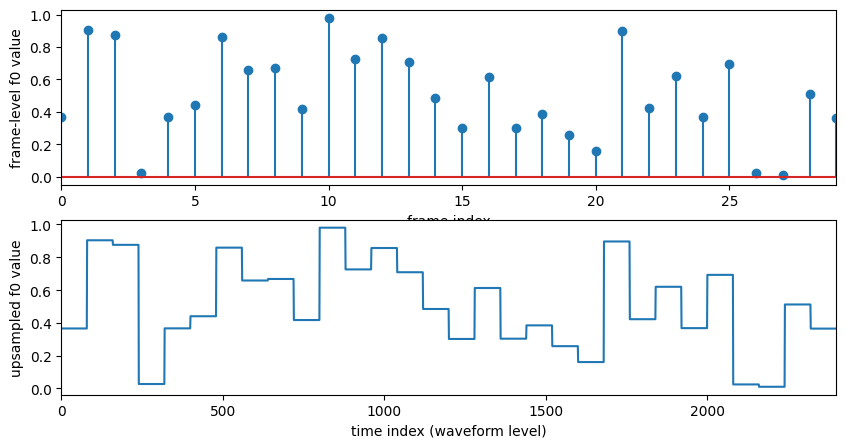

In [7]:
# Plot the F0
fig = plt.figure()
axis = fig.add_subplot(211)
fig, axis = plot_lib.plot_signal_stem(input_f0[0, :, 0].numpy(),
                                      fig, axis, "frame index", "frame-level f0 value")
axis = fig.add_subplot(212)
fig, axis = plot_lib.plot_signal(f0_upsampled[0, :, 0].numpy(),
                                 fig, axis, "time index (waveform level)",
                                 "upsampled f0 value")

## Sec.1.3 Source Module

```sh
-----------------------------------------------------
|             Source module                         |
|                          noise generator ----------> n_{1:N}
|                                                   |
|              ---> ...           --->              |
|     sine   --|--> harmonic ...  ---> Linear Tanh  -> e_{1:N}
|   generator  ---> fundamental com.->              |
|        ^                                          |
---------|-------------------------------------------
         |           
upsampled F0 f_{1:N}
```

Given the upsampled F0 $\boldsymbol{f}_{1:N}$, this module produces a source excitation signal $\boldsymbol{e}_{1:N}$:
1. It uses the sine generator defined in chapter_2_DSP_tools.ipynb to produce multiple sine signals -- fundamental component, 1st harmonic overtone, 2nd harmonic overtone ... ;
2. It uses a linear layer to merge the sine signals into $\boldsymbol{e}_{1:N}$.

$\boldsymbol{f}_{1:N}\in\mathbb{R}^{N}$, $\boldsymbol{e}_{1:N}\in\mathbb{R}^{N}$.

The noise $\boldsymbol{n}_{1:N}$ can be generated independently, for implementation, we simply put it inside the Source module.



### Sec.1.3.1 Pytorch Module


In [8]:
# SinGen is in the /content/data_models/pre_trained_hn_nsf/model.py
# For source module
class SourceModuleHnNSF(torch_nn.Module):
    """ SourceModule for hn-nsf
    SourceModule(sampling_rate, harmonic_num=0, sine_amp=0.1,
                 add_noise_std=0.003, voiced_threshod=0)
    sampling_rate: sampling_rate in Hz
    harmonic_num: number of harmonic overtone (default: 0)
    sine_amp: amplitude of sine source signal (default: 0.1)
    add_noise_std: std of additive Gaussian noise (default: 0.003)
        note that amplitude of noise in unvoiced is decided
        by sine_amp
    voiced_threshold: threhold to set U/V given F0 (default: 0)

    Sine_source, noise_source = SourceModuleHnNSF(F0_sampled)
    F0_sampled (batchsize, length, 1)
    Sine_source (batchsize, length, 1)
    noise_source (batchsize, length 1)
    uv (batchsize, length, 1)
    """
    def __init__(self, sampling_rate, harmonic_overtone_num=0, sine_amp=0.1,
                 add_noise_std=0.003, voiced_threshod=0):
        super(SourceModuleHnNSF, self).__init__()

        self.sine_amp = sine_amp
        self.noise_std = add_noise_std

        # to produce sine waveforms
        self.l_sin_gen = nii_nn_blocks.SineGen(
            sampling_rate, harmonic_overtone_num,
            sine_amp, add_noise_std, voiced_threshod)

        # to merge source harmonics into a single excitation
        self.l_linear = torch_nn.Linear(harmonic_overtone_num+1, 1)
        self.l_tanh = torch_nn.Tanh()

        # add a member to save intermediate results
        self.sine_wavs = None

    def forward(self, f0_upsampled):
        """
        Sine_source, noise_source = SourceModuleHnNSF(F0_sampled)
        F0_sampled (batchsize, length, 1)
        Sine_source (batchsize, length, 1)
        noise_source (batchsize, length 1)
        """
        # source for harmonic branch
        # generating the fundamental component and harmonic overtones
        # sine_wavs is in shape (batch, length, dim),
        #  where dim = 1 + number of harmonic overtones
        sine_wavs, uv, _ = self.l_sin_gen(f0_upsampled)
        self.sine_wavs = sine_wavs

        # merge harmonics into one signal
        sine_merge = self.l_tanh(self.l_linear(sine_wavs))

        # source for noise branch, in the same shape as uv
        noise = torch.randn_like(uv) * self.sine_amp / 3
        return sine_merge, noise, uv

`sine_merge` is the excitation signal $\boldsymbol{e}_{1:N}$.

`noise` is the noise $\boldsymbol{n}_{1:N}$.

Also returned is the voiced/unvoiced flag (`uv`). It is used later.

### Sec.1.3.2 Example Usage

Let's try to generate source signals for two data sequences in a single mini-batch.

In [9]:
#
# Create an up-sample F0 matrix
#   Here we try batchsize=2, length=24000
signal_length = 24000
upsampled_f0 = torch.ones(2, signal_length, 1)

# try a chirp signal in the 1st batch (50 - 1000 Hz)
upsampled_f0[0, :, 0] = torch.linspace(50, 1000, signal_length)
# try a constant F0 signal in the 2nd batch (100 Hz)
upsampled_f0[1, :, 0] = 100

# Create an source module
#   using 24kHz sampling rate,
#   2 harmonic overtones
sampling_rate = 24000
harmonic_overtone_num = 2
m_source = SourceModuleHnNSF(sampling_rate, harmonic_overtone_num)

# Generate source signals
with torch.no_grad():
    source_signal, noise_signal, uv = m_source(upsampled_f0)


print("Input upsampled_f0 has shape", str(upsampled_f0.shape))
print("Output source_signal has shape", str(source_signal.shape))

Input upsampled_f0 has shape torch.Size([2, 24000, 1])
Output source_signal has shape torch.Size([2, 24000, 1])


'Source signal with gradually increased F0'

'Source signal with constant F0'

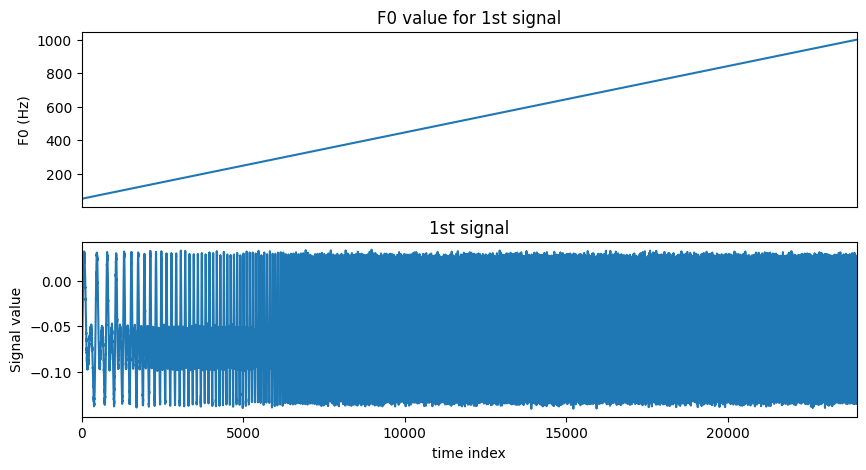

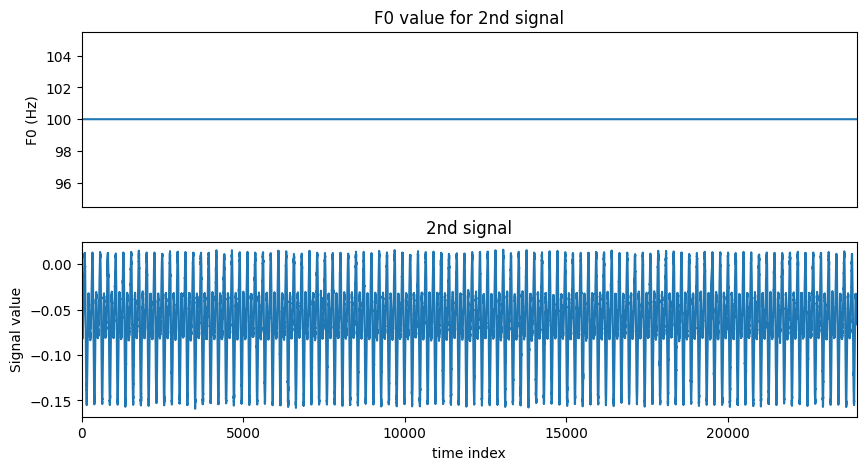

In [10]:
# Plot the figures


## The first signal
# plot F0 value
fig = plt.figure();
axis = fig.add_subplot(211);
fig, axis = plot_lib.plot_signal(upsampled_f0[0, :, 0], fig, axis,
                                 ylabel='F0 (Hz)', title='F0 value for 1st signal')
axis.set_xticks([])
# plot the signal
axis = fig.add_subplot(212);
fig, axis = plot_lib.plot_signal(source_signal[0, :, 0], fig, axis,
                                 xlabel='time index', ylabel='Signal value', title='1st signal')


## The second signal
fig = plt.figure();
axis = fig.add_subplot(211);
fig, axis = plot_lib.plot_signal(upsampled_f0[1, :, 0], fig, axis,
                                 ylabel='F0 (Hz)', title='F0 value for 2nd signal')
axis.set_xticks([])
# plot the signal
axis = fig.add_subplot(212);
fig, axis = plot_lib.plot_signal(source_signal[1, :, 0], fig, axis,
                                 xlabel='time index', ylabel='Signal value', title='2nd signal')


import IPython.display
# Play the signals.
IPython.display.display("Source signal with gradually increased F0")
IPython.display.display(IPython.display.Audio(source_signal[0, :, 0].numpy(), rate=sampling_rate))
IPython.display.display("Source signal with constant F0")
IPython.display.display(IPython.display.Audio(source_signal[1, :, 0].numpy(), rate=sampling_rate))


Source signals above are merged from fundamental and harmonic overtones.

To see each harmonic component, we can use the `m_source.sine_wavs`

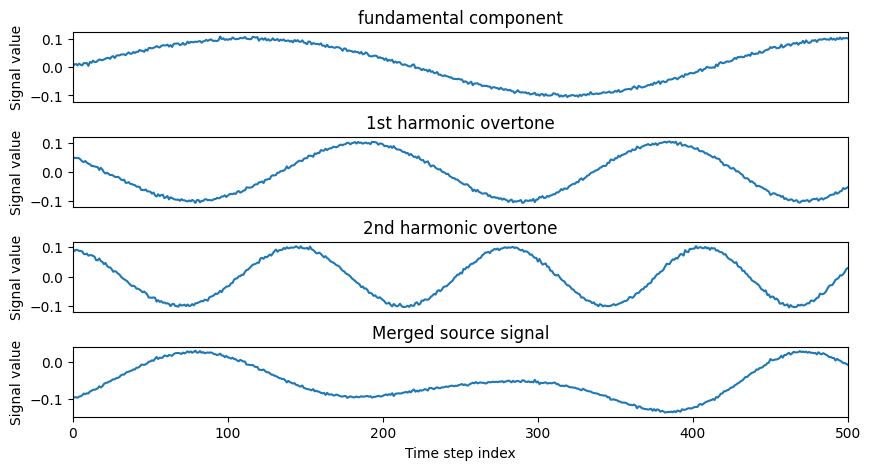

In [11]:
harmonic_idx = [0, 1, 2]
titles = ['fundamental component', '1st harmonic overtone', '2nd harmonic overtone']
fig = plt.figure();
for idx, title in zip(harmonic_idx, titles):
    axis = fig.add_subplot(len(harmonic_idx)+1, 1, idx+1);
    fig, axis = plot_lib.plot_signal(m_source.sine_wavs[0, :, idx],
                                     fig, axis, ylabel='Signal value', title=title)
    axis.set_xticks([])
    axis.set_xlim(0, 500)

axis = fig.add_subplot(len(harmonic_idx)+1, 1, len(harmonic_idx)+1);
fig, axis = plot_lib.plot_signal(source_signal[0, :, 0],
                                 fig, axis,
                                 xlabel="Time step index",
                                 ylabel='Signal value', title='Merged source signal')
axis.set_xlim(0, 500)
fig.subplots_adjust(hspace=0.5)

## Sec.1.4 Neural Filter Module

```sh

         --------------------------------------------
         |       Neural "filter" module             |
         |                                          |
         |                  Neural                  |
noise  --|---------------> "filter" -->  HP filter  |
         |                  block            |      |
         |                    |              + -----|--> waveform
         |                                   |      |
         |    neural    neural               |      |
source --|-> "filter"->"filter"->... ->  LP filter  |
signal   |    block      block                      |
         |      |---------|-------|                 |
         --------------------------------------------
                                 ^
                                 |
                    upsampled hidden features

```


A neural filter module has two branches:
1. a upper branch converts noise into one signal
2. a lower branch converts a source signal into another signal
3. both take upsampled hidden feature as input
4. the two signals are merged through high-pass (HP) and low-pass (HP) filters.


The HP and LP filters are time-invariant filter implemented in Pytorch (see chapter 3).

Each neural filter block consists of multiple 1D conv layers with skip-connection.  Notice that its input and output have the same shape

```sh
neural "filter" block

         |----------------------------------------------------------->|       
         |        ============>|  ============>|                      |
         |        |            v  |            v                      v
input ----> Linear => 1Dconv => +  => 1Dconv => +  ...  => + Linear - + -> output
                              ^               ^          ^            
                              |---------------|----------|
                              |
                    upsampled hidden features
```

### Sec.1.4.1 Pytorch Module


We first define the single neural "filter" block, then we define the full neural "filter" module.

#### A single neural "filter" block

In [12]:
# Neural filter block (1 block)
class NeuralFilterBlock(torch_nn.Module):
    """ Wrapper over a single filter block
    """
    def __init__(self, signal_size, hidden_size, \
                 kernel_size=3, conv_num=10):
        super(NeuralFilterBlock, self).__init__()
        # dimension of the input/output signal, which is usually 1
        self.signal_size = signal_size
        # dimension of the hidden features produced by dilated CNN
        self.hidden_size = hidden_size
        # kernel size of the CNN
        self.kernel_size = kernel_size
        # number of dilated 1D conv layers
        self.conv_num = conv_num
        # dilation size
        self.dilation_size = [np.power(2, x) for x in np.arange(conv_num)]

        # definition of the hidden layers
        #
        # ff layer to expand dimension
        self.l_ff_1 = torch_nn.Linear(signal_size, hidden_size, \
                                      bias=False)
        self.l_ff_1_tanh = torch_nn.Tanh()

        # dilated conv layers
        tmp = [nii_nn_blocks.Conv1dKeepLength(
                hidden_size, hidden_size, x, kernel_size,
                causal=True, bias=False) \
               for x in self.dilation_size]
        self.l_convs = torch_nn.ModuleList(tmp)

        # ff layer to de-expand dimension
        self.l_ff_2 = torch_nn.Linear(hidden_size, hidden_size//4,
                                      bias=False)
        self.l_ff_2_tanh = torch_nn.Tanh()
        self.l_ff_3 = torch_nn.Linear(hidden_size//4, signal_size,
                                      bias=False)
        self.l_ff_3_tanh = torch_nn.Tanh()

        # a simple scale
        # not necessary, just to be consistent with CURRENNT implementation
        self.scale = torch_nn.Parameter(torch.tensor([0.1]),
                                        requires_grad=False)
        return

    def forward(self, signal, context):
        """
        Assume: signal  (batchsize, length, signal_size)
                context (batchsize, length, hidden_size)
        Output: (batchsize, length, signal_size)
        """
        # expand dimension
        tmp_hidden = self.l_ff_1_tanh(self.l_ff_1(signal))

        # loop over dilated convs
        # output of a d-conv is input + context + d-conv(input)
        for l_conv in self.l_convs:
            tmp_hidden = tmp_hidden + l_conv(tmp_hidden) + context

        # to be consistent with legacy configuration in CURRENNT
        tmp_hidden = tmp_hidden * self.scale

        # compress the dimesion and skip-add
        tmp_hidden = self.l_ff_2_tanh(self.l_ff_2(tmp_hidden))
        tmp_hidden = self.l_ff_3_tanh(self.l_ff_3(tmp_hidden))
        output_signal = tmp_hidden + signal
        return output_signal

#### The full neural filter module

In [13]:
# For Filter module
class FilterModuleHnNSF(torch_nn.Module):
    """ Filter for Hn-NSF
    FilterModuleHnNSF(signal_size, hidden_size, fir_coef,
                      block_num = 5,
                      kernel_size = 3,
                      conv_num_in_block = 10)

    signal_size: signal dimension (should be 1)
    hidden_size: dimension of hidden features inside neural filter block
    fir_coef: list of FIR filter coeffs,
              (low_pass_1, low_pass_2, high_pass_1, high_pass_2)
    block_num: number of neural filter blocks in harmonic branch (default 5)
    kernel_size: kernel size in dilated CNN (default 3)
    conv_num_in_block: number of d-conv1d in one neural filter block (default 10)

    Method:
        output = FilterModuleHnNSF(harmonic_source, noise_source, uv, context)

        input:
            harmonic_source (batchsize, length, dim=1)
            noise_source  (batchsize, length, dim=1)
            context (batchsize, length, dim=1)
            uv (batchsize, length, dim=1)

        output:
            output (batchsize, length, dim=1)
    """
    def __init__(self, signal_size, hidden_size, filter_coef, \
                 block_num = 5, kernel_size = 3, conv_num_in_block = 10):
        super(FilterModuleHnNSF, self).__init__()
        # similar to the members in NeuralFilterBlock
        self.signal_size = signal_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.block_num = block_num
        self.conv_num_in_block = conv_num_in_block

        # A list of FIR filter coefficients
        self.filter_coef = filter_coef

        # filter blocks for harmonic branch
        tmp = [NeuralFilterBlock(signal_size, hidden_size, \
                                 kernel_size, conv_num_in_block) \
               for x in range(self.block_num)]
        self.l_har_blocks = torch_nn.ModuleList(tmp)

        # filter blocks for noise branch (only one block, 5 sub-blocks)
        tmp = [NeuralFilterBlock(signal_size, hidden_size, \
                                 kernel_size, conv_num_in_block // 2) \
               for x in range(1)]
        self.l_noi_blocks = torch_nn.ModuleList(tmp)

        # FIR filter groups
        # lp_v: filter for voiced region, harmonic component
        # lp_u: filter for unvoiced region, harmonic component
        # hp_v: filter for voiced region, noise component
        # hp_u: filter for unvoiced region, noise component
        self.l_fir_lp_v = nii_nn_blocks.TimeInvFIRFilter(signal_size, filter_coef[0])
        self.l_fir_lp_u = nii_nn_blocks.TimeInvFIRFilter(signal_size, filter_coef[1])
        self.l_fir_hp_v = nii_nn_blocks.TimeInvFIRFilter(signal_size, filter_coef[2])
        self.l_fir_hp_u = nii_nn_blocks.TimeInvFIRFilter(signal_size, filter_coef[3])

        # For debugging (not necessary for model training or generation)
        self.hidden_signals_har = []
        self.hidden_signals_noi = []
        self.uv = []

    def forward(self, har_component, noi_component, condition_feat, uv):
        """
        har_component (batchsize, length, dim=1)
        noi_component (batchsize, length, dim=1)
        condition_feat (batchsize, length, context_dim)
        uv (batchsize, length, dim=1), uv \in (0, 1)
        """
        self.hidden_signals_har = []
        self.hidden_signals_noi = []
        self.uv = []

        self.hidden_signals_har.append(har_component)
        # harmonic component
        for l_har_block in self.l_har_blocks:
            har_component = l_har_block(har_component, condition_feat)
            self.hidden_signals_har.append(har_component)

        # noise component
        self.hidden_signals_noi.append(noi_component)
        for l_noi_block in self.l_noi_blocks:
            noi_component = l_noi_block(noi_component, condition_feat)
            self.hidden_signals_noi.append(noi_component)

        # harmonic + noise in time-domain
        # assume uv is {0, 1}, produce a weight vector for voiced/unvoiced
        # sigmoid is used to ensure being (0, 1), and uv is scaled to {-5, 5}
        w_voi = torch.sigmoid((uv - 0.5) * 10)
        w_unv = 1.0 - w_voi

        har_v = self.l_fir_lp_v(har_component)
        har_u = self.l_fir_lp_u(har_component)
        noi_v = self.l_fir_hp_v(noi_component)
        noi_u = self.l_fir_hp_u(noi_component)

        output = (har_v + noi_v) * w_voi + (har_u + noi_u) * w_unv

        # save results for debugging, not necessary for training/generation
        self.hidden_signals_har.append(har_v)
        self.hidden_signals_har.append(har_u)
        self.hidden_signals_noi.append(noi_v)
        self.hidden_signals_noi.append(noi_u)
        self.uv.append(w_voi)

        return output


`self.l_fir_lp_v` and the other three FIR filters are implemented as `TimeInvFIRFilter` (see chapter 3).

The implementation uses two pairs of HP and LP filters, rather than one pair:
1. `l_fir_lp_v` and `l_fir_hp_v` for time steps where the waveform is voiced;
2. `l_fir_lp_u` and `l_fir_hp_u` for time steps where the waveform is unvoiced.

All of them are fixed and non-trainable in this implementation.
We need to provide the filter coefficients.


We will explain this in Sec.2.2.

## Sec.1.5 Wrap Up Full Model

Now we can define with a full model.



In [14]:
class HnNSFModel(torch_nn.Module):
    """ Model definition
    in_dim: dimension of input acoustic features
    out_dim: dimension of output waveform (usually 1)
    sampling_rate: sampling rate of output waveform
    feat_upsamp_rate: up-sampling rate on the input acoustic features
    """
    def __init__(self, in_dim, out_dim, sampling_rate, feat_upsamp_rate):
        super(HnNSFModel, self).__init__()
        torch.manual_seed(1)

        # mean std of input and output features for z-norm
        in_m, in_s, out_m, out_s = self.prepare_mean_std(in_dim,out_dim)
        self.input_mean = torch_nn.Parameter(in_m, requires_grad=False)
        self.input_std = torch_nn.Parameter(in_s, requires_grad=False)
        self.output_mean = torch_nn.Parameter(out_m, requires_grad=False)
        self.output_std = torch_nn.Parameter(out_s, requires_grad=False)

        # input and output dimension
        self.input_dim = in_dim
        self.output_dim = out_dim

        ####################################
        # Hyper-parameter configurations
        ####################################
        # amplitude of sine waveform (for each harmonic)
        self.sine_amp = 0.1
        # standard deviation of Gaussian noise for additive noise
        self.noise_std = 0.003
        # dimension of hidden features in filter blocks
        self.hidden_dim = 64

        # upsampling rate on input acoustic features (16kHz * 5ms = 80)
        # assume input_reso has the same value
        self.upsamp_rate = feat_upsamp_rate

        # sampling rate (Hz)
        self.sampling_rate = sampling_rate

        # CNN kernel size in filter blocks
        self.cnn_kernel_size = 3
        # number of filter blocks (for harmonic branch)
        # noise branch only uses 1 block
        self.filter_block_num = 5
        # number of dilated CNN in each filter block
        self.cnn_num_in_block = 10
        # number of harmonic overtone in source
        self.harmonic_num = 7

        ##########################################
        # FIR filter definition
        ##########################################
        # fixed filter coefficients
        # computed using PM algorithm
        # (tool: http://t-filter.engineerjs.com)
        #
        # low-pass for harmonic-component in voiced region
        #  16kHz, pass-band 0-5K, gain 1, ripple 5dB,
        #         stop-band 7-8k, gain 0, ripple -40dB)
        lp_v = [0.08538414199291068, 0.04920229475534168,-0.1470178606967731, 0.24737764593887432,0.7103067853166558, 0.24737764593887432,-0.1470178606967731, 0.04920229475534168,0.08538414199291068]

        # low-pass for harmonic-copmonent in unvoiced region
        #  16kHz, pass-band 0-1K, gain 1, ripple 5dB,
        #         stop-band 3-8k, gain 0, ripple -40dB)
        lp_u = [0.00936455546502, 0.0416254862901, 0.0878313219556,0.146086321198, 0.192602581136, 0.211221591449,0.192602581136, 0.146086321198, 0.0878313219556,0.0416254862901, 0.00936455546502]

        # high-pass for noise-component in voiced region
        #  16kHz, pass-band 7-8K, gain 1, ripple 5dB,
        #         stop-band 0-5k, gain 0, ripple -40dB)
        hp_v = [-0.00936455546502148, 0.04162548629009957, -0.08783132195564508, 0.1460863211980122,-0.19260258113649556, 0.21122159144894015,-0.19260258113649556, 0.1460863211980122,-0.08783132195564508, 0.04162548629009957,-0.00936455546502148]

        # high-pass for noise-component in unvoiced region
        #  16kHz, pass-band 3-8K, gain 1, ripple 5dB,
        #         stop-band 0-1k, gain 0, ripple -40dB)
        hp_u = [0.0853841419929, -0.0492022947553, -0.147017860697, -0.247377645939, 0.710306785317, -0.247377645939, -0.147017860697, -0.0492022947553, 0.0853841419929]

        self.fir_filters = [torch.tensor(lp_v), torch.tensor(lp_u),
                            torch.tensor(hp_v), torch.tensor(hp_u)]

        ##############################
        # the three modules
        ##############################
        self.m_condition = CondModule(
            self.input_dim, self.hidden_dim, self.upsamp_rate, \
            cnn_kernel_s = self.cnn_kernel_size)

        self.m_source = SourceModuleHnNSF(
            self.sampling_rate, self.harmonic_num, self.sine_amp, self.noise_std)

        self.m_filter = FilterModuleHnNSF(
            self.output_dim, self.hidden_dim, self.fir_filters, \
            self.filter_block_num, self.cnn_kernel_size, self.cnn_num_in_block)

        # done
        return

    def prepare_mean_std(self, in_dim, out_dim):
        in_m = torch.zeros([in_dim])
        in_s = torch.zeros([in_dim])
        out_m = torch.ones([out_dim])
        out_s = torch.ones([out_dim])
        return in_m, in_s, out_m, out_s

    def normalize_input(self, x):
        return (x - self.input_mean) / self.input_std

    def normalize_target(self, y):
        return (y - self.output_mean) / self.output_std

    def denormalize_output(self, y):
        return y * self.output_std + self.output_mean

    def forward(self, x):
        """ definition of forward method
        Assume x (batchsize, length, dim)
        Return output(batchsize, length)
        """
        # assume x[:, :, -1] is F0
        f0 = x[:, :, -1:]

        # normalize the input features
        feat = self.normalize_input(x)

        # condition module
        # features_for_filter_block, up-sampled F0
        cond_feat, f0_upsamped = self.m_condition(feat, f0)

        # source module
        # harmonic-source, noise-source (for noise branch), uv flag
        har_source, noi_source, uv = self.m_source(f0_upsamped)

        # filter module (including FIR filtering)
        # output signal
        output = self.m_filter(har_source, noi_source, cond_feat, uv)

        # output
        return output.squeeze(-1)

We will show how to use the above model in the next section.

# Sec.2 Demonstration on Speech Generation

## Sec.2.1 Generate a Speech Signal using a Pre-trained model


**Define and load a pre-trained model**

In [15]:
# input feature dim (80 dimension Mel-spec + 1 dimension F0)
mel_dim = 80
f0_dim = 1
input_dim = mel_dim + f0_dim

# output dimension = 1 for waveform
output_dim = 1
# sampling rate of waveform (Hz)
sampling_rate = 16000
# up-sampling rate of acoustic features (sampling_rate * frame_shift)
#   here the input acoustic features have a frame shift of 5ms
#   so, the upsampling rate of the acoustic features should be 80
feat_upsamp_rate = int(16000 * 0.005)

# declare the model
hn_nsf_model = HnNSFModel(input_dim, output_dim, sampling_rate, feat_upsamp_rate)

In [16]:
# load pre-trained model
device=torch.device("cpu")
hn_nsf_model.to(device, dtype=torch.float32)

model_path = os.path.join(g_workpath, "data_models/pre_trained_hn_nsf/trained_network.pt")
checkpoint = torch.load(model_path, map_location="cpu")
hn_nsf_model.load_state_dict(checkpoint)

<All keys matched successfully>

**Prepare input feature**

Here we will
1. use prepared scripts to extract F0 and Mel-spectrogram from a speech waveform.
2. feed the extracted acoustic features to produce the speech waveform.

This is an analysis-synthesis (or copy-synthesis) process, not text-to-speech.

In [17]:
# Load the tools for feature extraction
# The tools to extract are in data_models/scripts
sys.path.append(os.path.sep.join([os.getcwd(), 'data_models', 'scripts']))
sys.path.append(os.path.sep.join([os.getcwd(), 'data_models', 'scripts', 'f0_yaapt']))
import data_models.scripts.sub_get_mel as nii_mel_tk
import data_models.scripts.f0_yaapt.get_f0 as nii_f0_tk

#sampling_rate = 16000
# condition for copy-synthesis
fftl_n = 1024
frame_length = 400
frame_shift = feat_upsamp_rate
frame_length_in_ms = int(frame_length*1000/sampling_rate)
frame_shift_in_ms = int(frame_shift*1000/sampling_rate)

# Load waveform
input_waveform_path = os.path.join(g_workpath, "data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav")

# extract Mel-spectrogram
input_mel = nii_mel_tk.get_melsp(input_waveform_path,
                                 fftl=fftl_n, fl=frame_length, fs=frame_shift)
# extract F0
input_f0 = nii_f0_tk.extractF0_wrapper(input_waveform_path,
                                       frame_length=frame_length_in_ms,
                                       frame_shift=frame_shift_in_ms)

/content/data_models/scripts/f0_yaapt/amfm_decompy/pYAAPT.py:198: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if interp_tech is 'step':
/content/data_models/scripts/f0_yaapt/amfm_decompy/pYAAPT.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif interp_tech is 'pchip' or 'spline':
/content/data_models/scripts/f0_yaapt/amfm_decompy/pYAAPT.py:208: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if interp_tech is 'pchip':
/content/data_models/scripts/f0_yaapt/amfm_decompy/pYAAPT.py:212: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif interp_tech is 'spline':
/content/data_models/scripts/f0_yaapt/amfm_decompy/pYAAPT.py:231: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if interp_tech is 'pchip' and len(frame) > 2:
/content/data_models/scripts/f0_yaapt/amfm_decompy/pYAAPT.py:236: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif interp_tech is 'spline' and len(frame) > 2:


In [18]:
# If you have problem running the code above, please just load the pre-extracted features
if False:
    mel_path = os.path.join(g_workpath, "data_models/acoustic_features/hn_nsf/slt_arctic_b0474.mfbsp")
    input_mel = tool_lib.read_raw_mat(mel_path, mel_dim)
    f0_path = os.path.join(g_workpath, "data_models/acoustic_features/hn_nsf/slt_arctic_b0474.f0")
    input_f0 = tool_lib.read_raw_mat(f0_path, f0_dim)


In [19]:
print("Input Mel shape:" + str(input_mel.shape))
print("Input F0 shape:" + str(input_f0.shape))

# compose the input tensor
input_length = min([input_mel.shape[0], input_f0.shape[0]])
input_tensor = torch.zeros(1, input_length, mel_dim + f0_dim, dtype=torch.float32)
input_tensor[0, :, 0:mel_dim] = torch.tensor(input_mel[0:input_length, :])
input_tensor[0, :, mel_dim:] = torch.tensor(input_f0[0:input_length]).unsqueeze(-1)

print("Input data tensor shape:" + str(input_tensor.shape))

# The length of the Mel and F0 are slightly different due to the difference
# in the extraction tools.

Input Mel shape:(554, 80)
Input F0 shape:(549,)
Input data tensor shape:torch.Size([1, 549, 81])


**Generating the waveform**

In [20]:
with torch.no_grad():
    output_waveform = hn_nsf_model(input_tensor)

import IPython.display
IPython.display.Audio(output_waveform[0].numpy(), rate=sampling_rate)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='frame index', ylabel='frequency (kHz)'>)

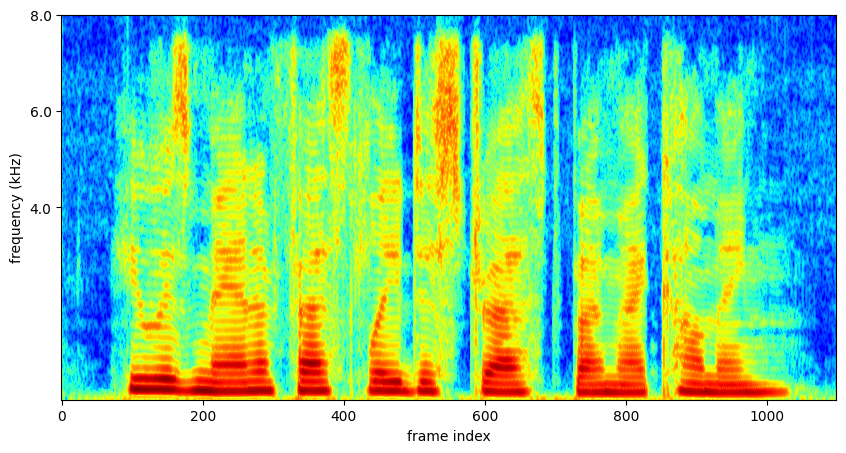

In [21]:
# plot the spectrogram of the generated waveform
spectrogram = tool_lib.spec_amplitude(output_waveform[0].numpy())

fig=plt.figure(); axis=fig.add_subplot(111);
plot_lib.plot_spectrogram(spectrogram, fig, axis,
                          "frame index", "frequency (kHz)",
                          sampling_rate = sampling_rate)

You may also try other waveforms in data_models/acoustic_features/hn_nsf.


In [22]:
!ls /content/data_models/acoustic_features/hn_nsf/ | grep wav

bdl_arctic_b0474.wav
clb_arctic_b0474.wav
rms_arctic_b0474.wav
slt_arctic_b0474.wav


## Sec.2.2 Analysis Hidden features

Remember that the input and output of neural filter blocks are a batch of waveforms.

We can listen to the output from each neural filter block.

```sh
         --------------------------------------------
         |       Neural "filter" module             |
         |                                          |
         |                  Neural                  |
noise  --|---------------> "filter" -->  HP filter  |
         |                  block            |      |
         |                    |              + -----|--> waveform
         |                                   |      |
         |    neural    neural               |      |
source --|-> "filter"->"filter"->... ->  LP filter  |
signal   |    block      block                      |
         |      |---------|-------|                 |
         --------------------------------------------
                                 ^
                                 |
                    upsampled hidden features
```

In module `FilterModuleHnNSF`, we prepare two buffers to store the output from each neural filter block:
1. `FilterModuleHnNSF.hidden_signals_har`: the hidden signals in the harmonic branch
2. `FilterModuleHnNSF.hidden_signals_noi`: the hidden signals in the noise branch
We will load the signals from those buffers

In [23]:
# For convenience, define a wrapper to plot figures

def plot_signal_and_spec(signal_list, name_buffer, sampling_rate):
    # to get spectrogram
    f_spec_function = lambda x: tool_lib.spec_amplitude(x, fft_bins=4096, frame_shift=40, frame_length=240)

    #
    fig = plt.figure(figsize=(10, len(name_buffer)*2));
    for idx, (signal, signal_name) in enumerate(zip(signal_list, name_buffer)):
        signal_tmp = signal
        #
        axis = fig.add_subplot(len(name_buffer), 2, idx * 2 + 1)
        plot_lib.plot_signal(signal_tmp, fig, axis, 'time step', 'waveform value', signal_name)
        if idx < (len(name_buffer)-1):
            axis.set_xticks([]);axis.set_xlabel('')

        spec = f_spec_function(signal_tmp)
        axis = fig.add_subplot(len(name_buffer), 2, idx * 2 + 2)
        plot_lib.plot_spectrogram(spec, fig, axis, "frame index", "frequency (kHz)", sampling_rate = sampling_rate)
        if idx < (len(name_buffer)-1):
            axis.set_xticks([]);axis.set_xlabel('')

        IPython.display.display(signal_name)
        IPython.display.display(IPython.display.Audio(signal_tmp, rate=sampling_rate))

### Harmonic branch

We first check the harmonic branch



'sine-source'

'1st neural filter block'

'2nd neural filter block'

'3rd neural filter block'

'4th neural filter block'

'5th neural filter block'

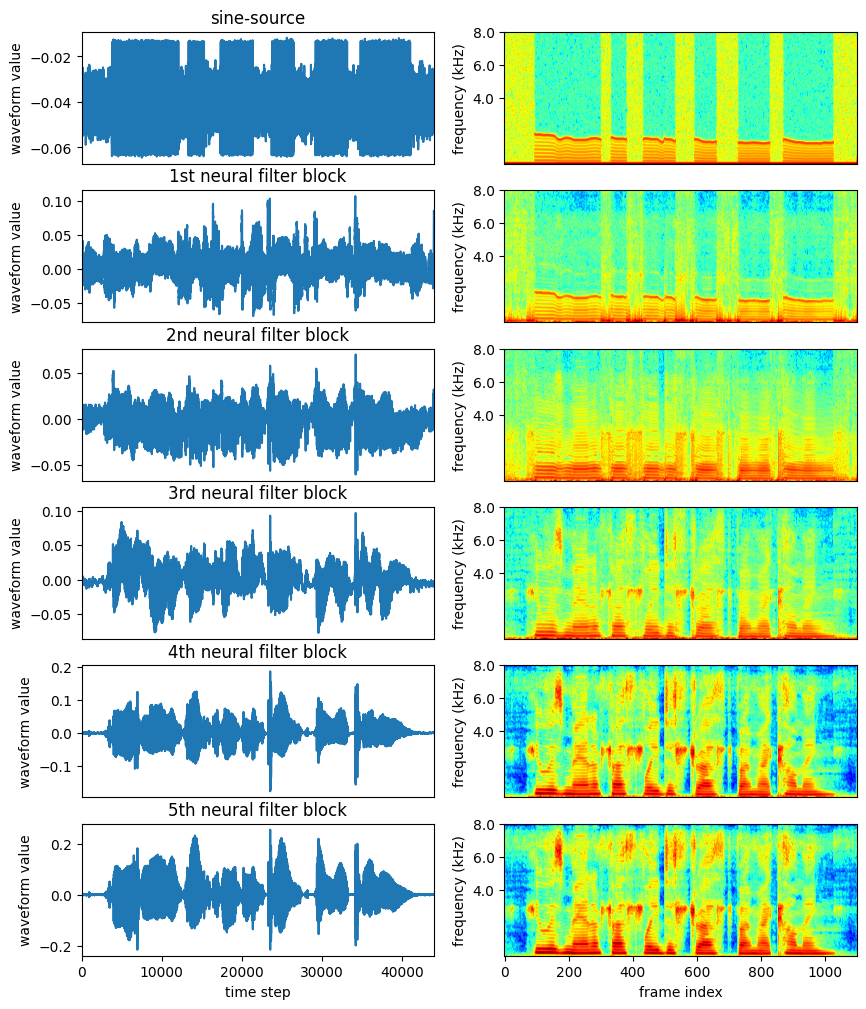

In [24]:
# For harmonic branch
name_buffer = ['sine-source',
               '1st neural filter block',
               '2nd neural filter block',
               '3rd neural filter block',
               '4th neural filter block',
               '5th neural filter block']

# convert from (batch, length, din) to numpy array
signal_list = [x[0, :, 0].numpy() for x in hn_nsf_model.m_filter.hidden_signals_har]

# plot
plot_signal_and_spec(signal_list, name_buffer, sampling_rate)


# Please lower the volume before playing the sound!

### Noise branch

'noise-source'

'1st neural filter block'

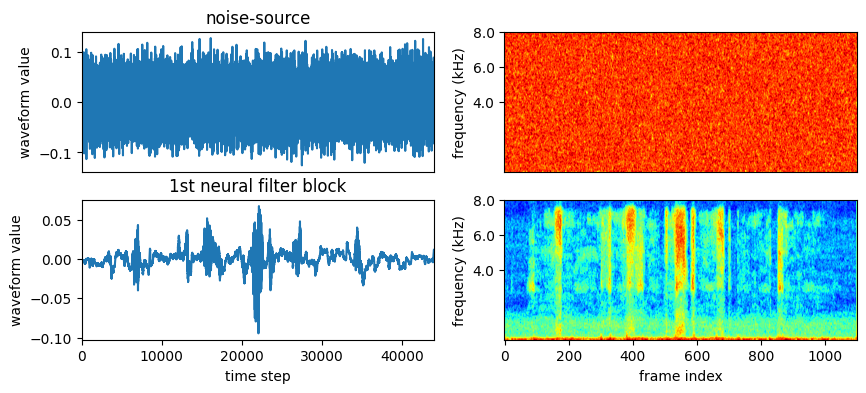

In [25]:
# For noise branch
name_buffer = ['noise-source', '1st neural filter block']
signal_list = [x[0, :, 0].numpy() for x in hn_nsf_model.m_filter.hidden_signals_noi]
plot_signal_and_spec(signal_list, name_buffer, sampling_rate)

### Merge the two

Previously, we plotted
```sh

         ---------------------------------------------
                                                     |
                               signal2 ->  HP filter |
                                             |       |
                                             + ------|--> waveform
                                             |       |
                               signal1 ->  LP filter |
                                                     |
                                    ------------------

```

The filter coefficients should change depending on whether the current time step is voiced or unvoiced.

They are be implemented as time-variant filters, but it is more convenient to just implement two sets of time-invariant filters, one for voiced segments and another for unvoiced segments. Finally, we merge them into an output waveform.

Thus, the actual implementation is:

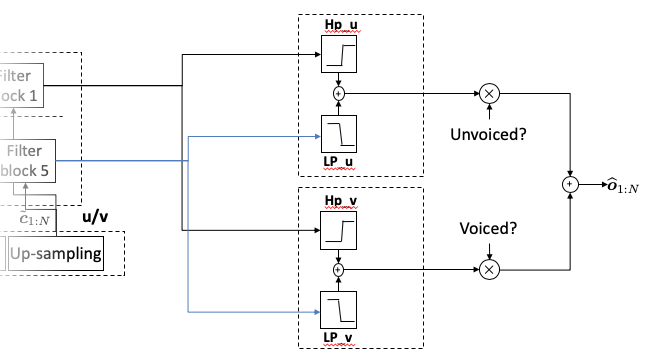

In [26]:
Image("/content/figures/fig_s1_6.png")

Let's check how the output of the harmonic branch is processed:

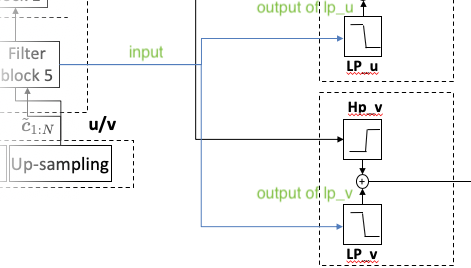

'input to lp filters'

'output of lp_u'

'output of lp_v'

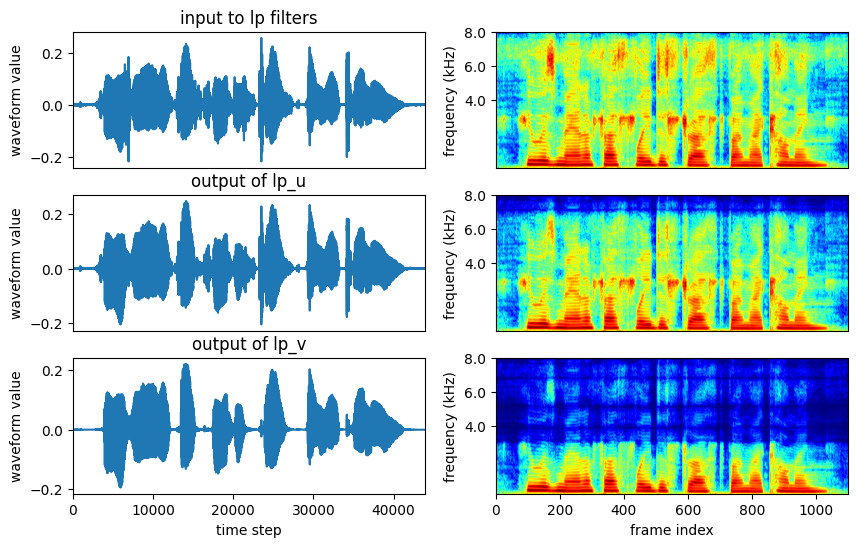

In [28]:
# plot the illustration
IPython.display.display(Image("/content/figures/fig_s1_6_2.png"))


# visualize the signals
name_buffer = ['input to lp filters', 'output of lp_u', 'output of lp_v']

# get the signals
har_input = hn_nsf_model.m_filter.hidden_signals_har[-3][0, :, 0].numpy()
har_v = hn_nsf_model.m_filter.hidden_signals_har[-2][0, :, 0].numpy()
har_u = hn_nsf_model.m_filter.hidden_signals_har[-1][0, :, 0].numpy()
signal_list = [har_input, har_v, har_u]

plot_signal_and_spec(signal_list, name_buffer, sampling_rate)


As the figures show, the output of `lp_v` filter has energy above 4kHz, while that of `lp_u` is only up to 3kHz.

This is expected because `lp_v` and `lp_u` have cut-off frequencies around 7 kHz and 3 kHz, respectively.  


The output of the noise branch is processed by:

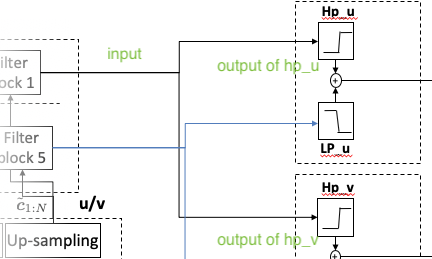

'input to hp filters'

'output of hp_u'

'output of hp_v'

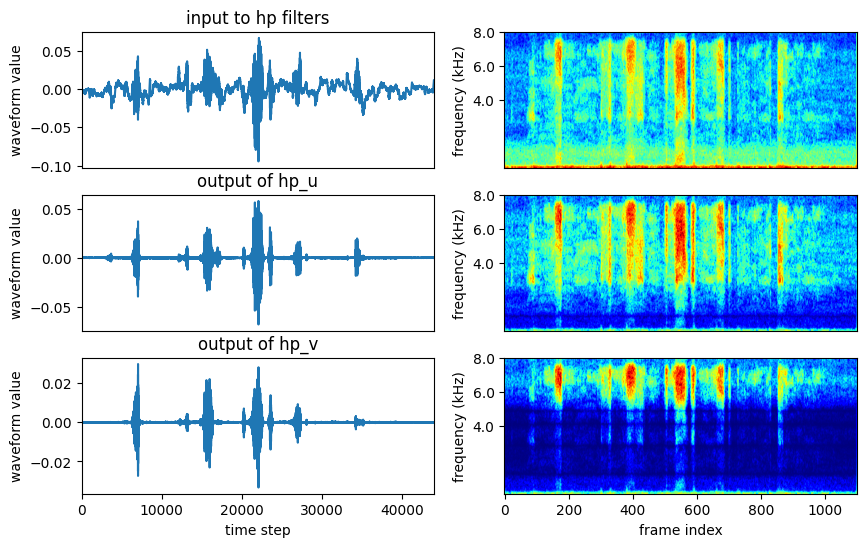

In [29]:
# plot the illustration
IPython.display.display(Image("/content/figures/fig_s1_6_3.png"))


name_buffer = ['input to hp filters', 'output of hp_u', 'output of hp_v']

# get the signals
noi_input = hn_nsf_model.m_filter.hidden_signals_noi[-3][0, :, 0].numpy()
noi_v = hn_nsf_model.m_filter.hidden_signals_noi[-2][0, :, 0].numpy()
noi_u = hn_nsf_model.m_filter.hidden_signals_noi[-1][0, :, 0].numpy()
signal_list = [noi_input, noi_u, noi_v]

plot_signal_and_spec(signal_list, name_buffer, sampling_rate)

Finally, we merge `hp_u`, `hp_v`, `lp_u`, and `lp_v` with the help of the U/V.

The final figure is the output from the whole model


'harmoic filtered using lp v'

'harmoic filtered using lp u'

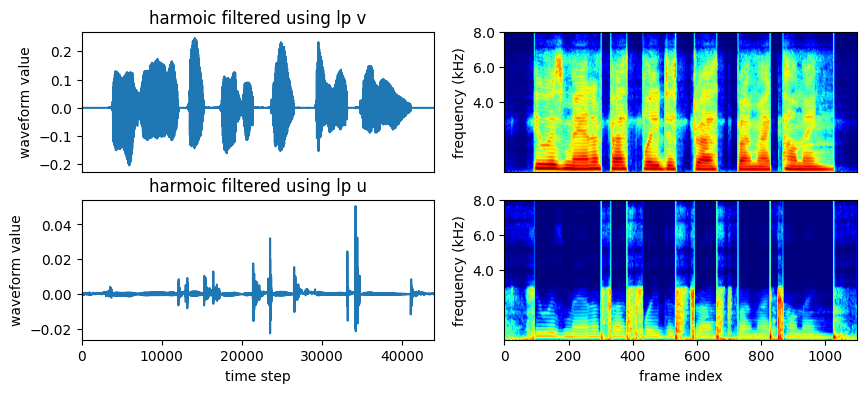

In [30]:
w_voi = hn_nsf_model.m_filter.uv[0][0, :, 0].numpy()
w_unv = 1.0-hn_nsf_model.m_filter.uv[0][0, :, 0].numpy()

name_buffer = ['harmoic filtered using lp v', 'harmoic filtered using lp u']
signal_list = [har_v * w_voi, har_u * w_unv]

plot_signal_and_spec(signal_list, name_buffer, sampling_rate)


'noise filtered using hp v'

'noise filtered using hp u'

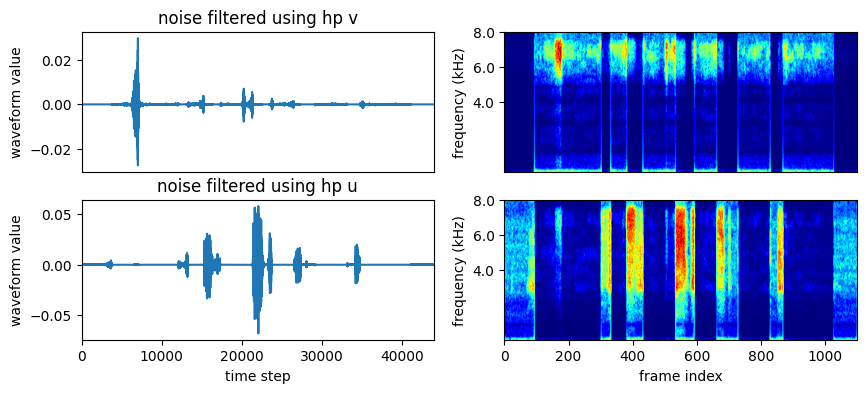

In [31]:
name_buffer = ['noise filtered using hp v', 'noise filtered using hp u']
signal_list = [noi_v * w_voi, noi_u * w_unv]


plot_signal_and_spec(signal_list, name_buffer, sampling_rate)

'harmoic filtered'

'noise filtered'

'harmonic + noise'

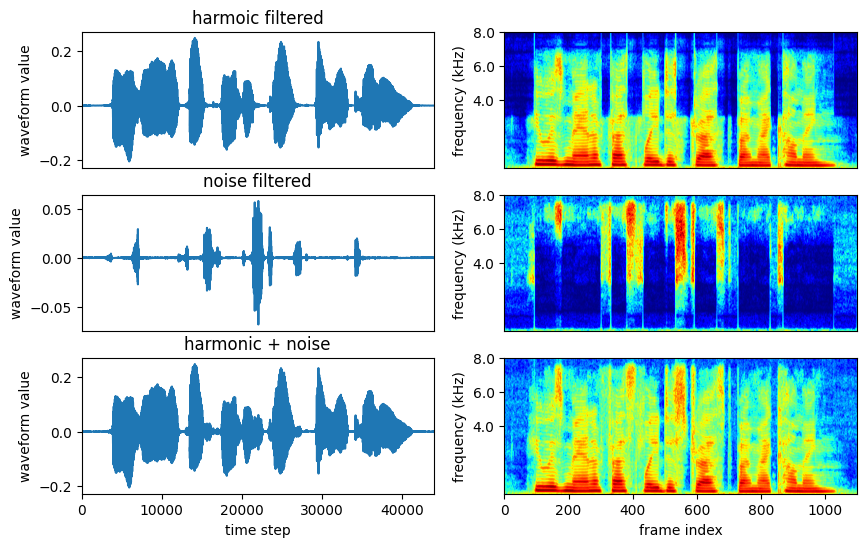

In [32]:
har = har_v * w_voi + har_u * w_unv
noi = noi_v * w_voi + noi_u * w_unv

name_buffer = ['harmoic filtered', 'noise filtered', 'harmonic + noise']
signal_list = [har, noi, har+noi]



plot_signal_and_spec(signal_list, name_buffer, sampling_rate)

# Sec.3 Modifying HnNSF for Music Instrument Audio Generation

Music instrumental audio signals do not need to separate noise and harmonic branches. We can remove the noise branch and HP and LP filters.

We prepare a detailed notebook (chapter_a2_MusicNSF.ipynb) to show the details.

Here we simply call the module definition in `/content/data_models/pre_trained_music_nsf/model.py` and do a simple demonstration.


## Sec.3.1 Create a MusicNSF



In [33]:
import sys
sys.path.append(os.path.sep.join([os.getcwd(), 'data_models', 'scripts', 'f0_yaapt']))
sys.path.append(os.path.sep.join([os.getcwd(), 'data_models', 'scripts', 'mel_librosa']))
import data_models.pre_trained_music_nsf.model as nii_music_NSF

class MusicNSF(torch_nn.Module):
    """ Model definition
    in_dim: dimension of input acoustic features
    out_dim: dimension of output waveform (usually 1)
    sampling_rate: sampling rate of output waveform
    feat_upsamp_rate: up-sampling rate on the input acoustic features
    """
    def __init__(self, in_dim, out_dim, sampling_rate, feat_upsamp_rate):
        super(MusicNSF, self).__init__()
        torch.manual_seed(1)

        # mean std of input and output features for z-norm
        in_m, in_s, out_m, out_s = self.prepare_mean_std(in_dim,out_dim)
        self.input_mean = torch_nn.Parameter(in_m, requires_grad=False)
        self.input_std = torch_nn.Parameter(in_s, requires_grad=False)
        self.output_mean = torch_nn.Parameter(out_m, requires_grad=False)
        self.output_std = torch_nn.Parameter(out_s, requires_grad=False)

        # input and output dimension
        self.input_dim = in_dim
        self.output_dim = out_dim

        ####################################
        # Hyper-parameter configurations
        ####################################
        # amplitude of sine waveform (for each harmonic)
        self.sine_amp = 0.1
        # standard deviation of Gaussian noise for additive noise
        self.noise_std = 0.003
        # dimension of hidden features in filter blocks
        self.hidden_dim = 64

        # upsampling rate on input acoustic features (16kHz * 5ms = 80)
        # assume input_reso has the same value
        self.upsamp_rate = feat_upsamp_rate

        # sampling rate (Hz)
        self.sampling_rate = sampling_rate

        # CNN kernel size in filter blocks
        self.cnn_kernel_size = 3
        # number of filter blocks (for harmonic branch)
        # noise branch only uses 1 block
        self.filter_block_num = 5
        # number of dilated CNN in each filter block
        self.cnn_num_in_block = 10
        # number of harmonic overtone in source (16 for music)
        self.harmonic_num = 16

        ##############################
        # the three modules
        ##############################
        self.m_condition = nii_music_NSF.CondModule(
            self.input_dim, self.hidden_dim, self.upsamp_rate, \
            cnn_kernel_s = self.cnn_kernel_size)

        self.m_source = nii_music_NSF.SourceModuleMusicNSF(
            self.sampling_rate, self.harmonic_num, self.sine_amp, self.noise_std)

        self.m_filter = nii_music_NSF.FilterModuleMusicNSF(
            self.output_dim, self.hidden_dim, \
            self.filter_block_num, self.cnn_kernel_size, self.cnn_num_in_block)

        # done
        return

    def prepare_mean_std(self, in_dim, out_dim):
        in_m = torch.zeros([in_dim])
        in_s = torch.zeros([in_dim])
        out_m = torch.ones([out_dim])
        out_s = torch.ones([out_dim])
        return in_m, in_s, out_m, out_s

    def normalize_input(self, x):
        return (x - self.input_mean) / self.input_std

    def normalize_target(self, y):
        return (y - self.output_mean) / self.output_std

    def denormalize_output(self, y):
        return y * self.output_std + self.output_mean

    def forward(self, x):
        """ definition of forward method
        Assume x (batchsize, length, dim)
        Return output(batchsize, length)
        """
        # assume x[:, :, -1] is F0
        f0 = x[:, :, -1:]

        # normalize the input features
        feat = self.normalize_input(x)

        # condition module
        # features_for_filter_block, up-sampled F0
        cond_feat, f0_upsamped = self.m_condition(feat, f0)

        # source module
        # harmonic-source,
        # no need to use noise-source or uv flag
        har_source, _, _ = self.m_source(f0_upsamped)

        # filter module (including FIR filtering)
        # output signal
        output = self.m_filter(har_source, None, cond_feat, None)

        # output
        return output.squeeze(-1)

In [34]:
# input feature dim (80 dimension Mel-spec + 1 dimension F0)
mel_dim = 80
f0_dim = 1
input_dim = mel_dim + f0_dim

# output dimension = 1 for waveform
output_dim = 1
# sampling rate of waveform (Hz)
sampling_rate = 24000
# up-sampling rate of acoustic features (sampling_rate * frame_shift)
feat_upsamp_rate = int(24000 * 0.012)


# declare the model

music_nsf_model = MusicNSF(input_dim, output_dim, sampling_rate, feat_upsamp_rate)

## Sec.3.2 Generate a Music Audio Signal using a Pre-trained Model

We will do copy-synthesis using data provided in [URMP database](http://www2.ece.rochester.edu/projects/air/projects/URMP.html).



In [35]:
# load pre-trained model
device=torch.device("cpu")
music_nsf_model.to(device, dtype=torch.float32)

model_path = os.path.join(g_workpath, "data_models/pre_trained_music_nsf/trained_network.pt")
checkpoint = torch.load(model_path, map_location="cpu")
music_nsf_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [36]:
!ls /content/data_models/acoustic_features/music_nsf/ | grep mfbsp | sed "s:.mfbsp::g"


AuSep_1_tpt_43_Chorale_0
AuSep_1_tpt_43_Chorale_1
AuSep_2_tpt_43_Chorale_0
AuSep_2_tpt_43_Chorale_1
AuSep_3_hn_43_Chorale_0
AuSep_3_hn_43_Chorale_1
AuSep_4_tbn_43_Chorale_0
AuSep_4_tbn_43_Chorale_1
AuSep_5_tba_43_Chorale_0
AuSep_5_tba_43_Chorale_1


In [37]:
# Choose one from the prepared data above
filename = 'AuSep_1_tpt_43_Chorale_0'

In [43]:
# get input features
#
# The tools to extract are in data_models/scripts
import data_models.scripts.mel_librosa.audio as librosa_mel
import data_models.scripts.f0_yaapt.get_f0 as nii_f0_tk

frame_length_in_ms = 24
frame_shift_in_ms = 12

input_waveform_path = os.path.join(g_workpath, "data_models/acoustic_features/music_nsf/{:s}.wav".format(filename))
input_mel = librosa_mel.get_melsp_librosa(input_waveform_path)

# URMP includes golden F0. Just use it.
# However, if you want to extracting F0 using this tool, please have a try (it doesn't work so well)
if False:
    input_f0 = nii_f0_tk.extractF0_wrapper(input_waveform_path,
                                           frame_length=frame_length_in_ms,
                                           frame_shift=frame_shift_in_ms)
else:
    input_mel_path = os.path.join(g_workpath, "data_models/acoustic_features/music_nsf/{:s}.mfbsp".format(filename))
    input_f0_path = os.path.join(g_workpath, "data_models/acoustic_features/music_nsf/{:s}.f0".format(filename))
    input_mel = tool_lib.read_raw_mat(input_mel_path, mel_dim)
    input_f0 = tool_lib.read_raw_mat(input_f0_path, f0_dim)


TypeError: ignored

In [39]:
print("Input Mel shape:" + str(input_mel.shape))
print("Input F0 shape:" + str(input_f0.shape))

# compose the input tensor
input_length = min([input_mel.shape[0], input_f0.shape[0]])
input_tensor = torch.zeros(1, input_length, mel_dim + f0_dim, dtype=torch.float32)
input_tensor[0, :, 0:mel_dim] = torch.tensor(input_mel[0:input_length, :])
input_tensor[0, :, mel_dim:] = torch.tensor(input_f0[0:input_length]).unsqueeze(-1)

print("Input data tensor shape:" + str(input_tensor.shape))

Input Mel shape:(554, 80)
Input F0 shape:(549,)
Input data tensor shape:torch.Size([1, 549, 81])


(<Figure size 1000x500 with 1 Axes>, <Axes: ylabel='Octave'>)

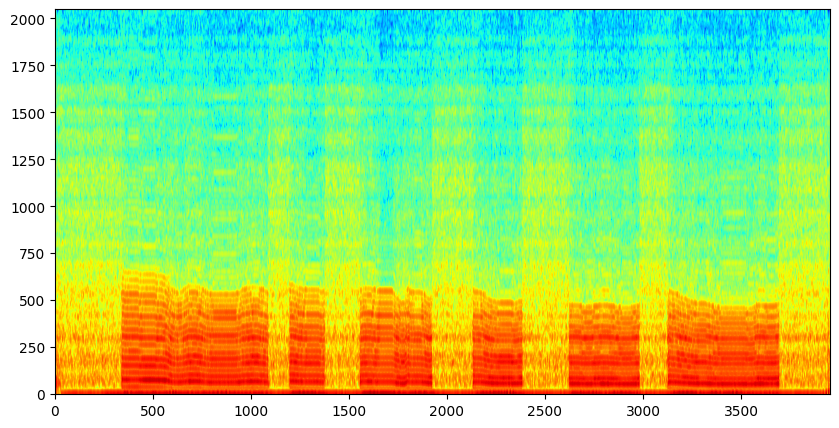

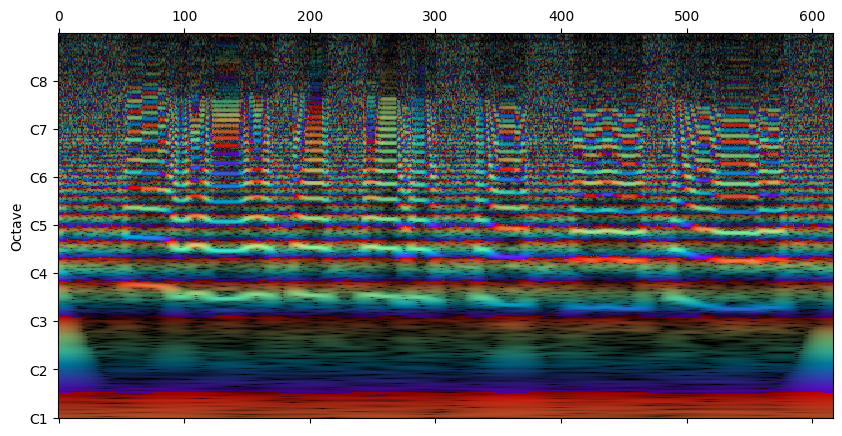

In [40]:
with torch.no_grad():
    output_waveform = music_nsf_model(input_tensor)


IPython.display.display(IPython.display.Audio(output_waveform[0].numpy(), rate=sampling_rate))

# plot the spectrogram of the generated waveform
spectrogram = tool_lib.spec_amplitude(output_waveform[0].numpy(), fft_bins=4096, frame_shift=40, frame_length=240)
fig=plt.figure()
axis=fig.add_subplot(111)
axis.imshow(spectrogram, aspect='auto', origin='lower', cmap='jet')

# plot the rainbow gram
fig=plt.figure()
axis=fig.add_subplot(111)
import plot_rainbow
plot_rainbow.plot_rainbow(output_waveform[0].numpy(), sampling_rate, fig, axis)


The chapter_a2_music_NSF.ipynb has more details on the hidden features and so on.

## Sec.3.3 Generate an Orchestra

We can produce multiple instrument signals and mix them together.

Generating multiple data may some time on CPU.

In [41]:
data_list = ['AuSep_1_tpt_43_Chorale_1', 'AuSep_3_hn_43_Chorale_1', 'AuSep_5_tba_43_Chorale_1',
             'AuSep_2_tpt_43_Chorale_1', 'AuSep_4_tbn_43_Chorale_1']
output_buffer = []
with torch.no_grad():
    for data_name in data_list:
        print("Generating", data_name)
        input_mel_path = os.path.join(g_workpath, "data_models/acoustic_features/music_nsf/{:s}.mfbsp".format(data_name))
        input_mel = tool_lib.read_raw_mat(input_mel_path, mel_dim)
        input_f0_path = os.path.join(g_workpath, "data_models/acoustic_features/music_nsf/{:s}.f0".format(data_name))
        input_f0 = tool_lib.read_raw_mat(input_f0_path, f0_dim)

        input_length = min([input_mel.shape[0], input_f0.shape[0]])
        input_tensor = torch.zeros(1, input_length, mel_dim + f0_dim, dtype=torch.float32)
        input_tensor[0, :, 0:mel_dim] = torch.tensor(input_mel[0:input_length, :])
        input_tensor[0, :, mel_dim:] = torch.tensor(input_f0[0:input_length]).unsqueeze(-1)
        output_waveform = music_nsf_model(input_tensor)
        output_buffer.append(output_waveform)

Generating AuSep_1_tpt_43_Chorale_1
Generating AuSep_3_hn_43_Chorale_1
Generating AuSep_5_tba_43_Chorale_1
Generating AuSep_2_tpt_43_Chorale_1
Generating AuSep_4_tbn_43_Chorale_1


In [42]:
# create a mixed stereo audio
# put two signals in left channel, put other signals in right channel
mixed_audio = np.zeros([2, output_buffer[0].shape[1]])
mixed_audio[0, :] += output_buffer[0][0].numpy()
mixed_audio[0, :] += output_buffer[1][0].numpy()
mixed_audio[1, :] += output_buffer[2][0].numpy()
mixed_audio[1, :] += output_buffer[3][0].numpy()
mixed_audio[1, :] += output_buffer[4][0].numpy()

import IPython.display
IPython.display.Audio(mixed_audio, rate=sampling_rate)

# Sec.4 Combining NSF with GAN

NSF uses only STFT loss. It is possible to use the NSF as a generator and train it using the GAN framework.

This is close to the [parallel WaveGAN](https://arxiv.org/abs/1910.11480).

We can also combine NSF with other types of discriminators.

We will show one example of NSF combined with HiFiGAN discriminators in chapter_9.

That's all!

# License
```
BSD 3-Clause License

Copyright (c) 2022, Xin Wang, National Institute of Informatics
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```

The used audio sample is from [CMU Arctic database](http://www.festvox.org/cmu_arctic/):

```
Kominek, John, and Alan W. Black. "The CMU Arctic speech databases." Fifth ISCA workshop on speech synthesis. 2004.
```

```
This voice is free for use for any purpose (commercial or otherwise)
subject to the pretty light restrictions detailed below.

############################################################################
###                                                                       ##
###                     Carnegie Mellon University                        ##
###                         Copyright (c) 2003                            ##
###                        All Rights Reserved.                           ##
###                                                                       ##
###  Permission to use, copy, modify,  and licence this software and its  ##
###  documentation for any purpose, is hereby granted without fee,        ##
###  subject to the following conditions:                                 ##
###   1. The code must retain the above copyright notice, this list of    ##
###      conditions and the following disclaimer.                         ##
###   2. Any modifications must be clearly marked as such.                ##
###   3. Original authors' names are not deleted.                         ##
###                                                                       ##
###  THE AUTHORS OF THIS WORK DISCLAIM ALL WARRANTIES WITH REGARD TO      ##
###  THIS SOFTWARE, INCLUDING ALL IMPLIED WARRANTIES OF MERCHANTABILITY   ##
###  AND FITNESS, IN NO EVENT SHALL THE AUTHORS BE LIABLE FOR ANY         ##
###  SPECIAL, INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES            ##
###  WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN   ##
###  AN ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION,          ##
###  ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF       ##
###  THIS SOFTWARE.                                                       ##
###                                                                       ##
############################################################################
###                                                                       ##
###  See http://www.festvox.org/cmu_arctic/ for more details              ##
###                                                                       ##
############################################################################

```

# ACKNOWLEDGEMENT

We thank CMU for providing the CMU Arctic database.

This work is partially supported by JST CREST Grants (JPMJCR18A6 and JPMJCR20D3), MEXT KAKENHI Grants (21K17775, 21H04906).